In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('./data/')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 10
n_class = 3
seed = 42

In [5]:
algo_name = 'rf_cv_last1'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 25)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_zi,d_dered_zr,d_dered_zg,d_dered_zu,d_dered_ir,d_dered_ig,d_dered_iu,d_dered_ru,d_dered_gu,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-0.7232,-2.0462,-3.3488,-6.2153,-1.3230,-2.6257,-5.4921,-4.1691,-2.8665,6.1132
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.1016,-0.2767,-0.8698,-1.8317,-0.1751,-0.7683,-1.7302,-1.5550,-0.9619,1.4427
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.0257,-0.1440,-0.3905,-1.3116,-0.1183,-0.3649,-1.2859,-1.1676,-0.9211,1.8205
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-0.2395,-0.5321,-1.4395,-5.7985,-0.2926,-1.2000,-5.5590,-5.2664,-4.3590,1.8640
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-0.3144,-0.9871,-2.5579,-5.8955,-0.6727,-2.2436,-5.5811,-4.9084,-3.3376,4.5471


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 24) (80000, 24)


# RF 첫번째

In [8]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [9]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = RandomForestClassifier(n_estimators=1024,
                                 max_depth=30,
                                 min_samples_leaf=128,
                                 max_samples=.7,
                                 max_features = 'auto',
                                 random_state=seed,
                                 n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5
training model for CV #6
training model for CV #7
training model for CV #8
training model for CV #9
training model for CV #10


In [10]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

92.5547%


In [11]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [12]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

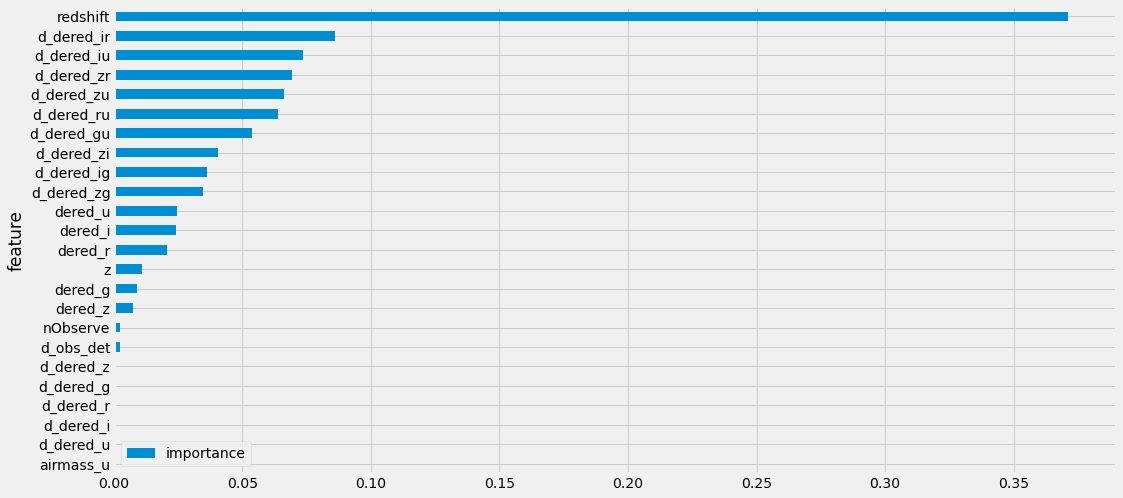

In [13]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [14]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [15]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [16]:
sub[target_col].value_counts()

2    41699
0    29923
1     8378
Name: class, dtype: int64

In [17]:
sub.to_csv(sub_file)

# RF 두번째

In [18]:
algo_name = 'rf_cv_last2'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [19]:
cv = StratifiedKFold(n_splits=n_fold-3, shuffle=True, random_state=seed)

In [20]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = RandomForestClassifier(n_estimators=1024,
                                 max_depth=50,
                                 min_samples_leaf=128,
                                 max_samples=.8,
                                 max_features = 'auto',
                                 random_state=seed,
                                 n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5
training model for CV #6
training model for CV #7


In [21]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

92.5663%


In [22]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [23]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [24]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [25]:
sub[target_col].value_counts()

2    41708
0    29922
1     8370
Name: class, dtype: int64

In [26]:
sub.to_csv(sub_file)